![Qiskit](https://github.com/Qiskit/qiskit-tutorials/raw/115c78962dda85bac29d679063b7d0d0ab1d1ab4/images/qiskit-heading.gif)

# Fitting Non-linear Distributions with Quantum Machine Learning Models in Aqua

donny@ibm.com

# Motivation: Minsky-Papert Perceptron Xor Problem

Minsky and Papert famously showed that the perceptron cannot fit the simple xor function. Multi-layer perceptrons, or neural networks, were shown to solve this shortcoming easily.

![Xor Problem](https://cdn-images-1.medium.com/max/1600/1*wEomny4n9fzKL7X9TABWjw.png)

# What Can We Fit With a Quantum Circuit?

Specifically, see the circuit as a non-linear function from the rotation parameters to the squared output statevector (and in the case of classification, the classification probabilities).

Let's try the Aqua Quantum Variational SVM to learn some non-linear functions, and explore the role of depth.

In [1]:
#Supress warnings for presentation
import warnings
warnings.filterwarnings("ignore")

First, install Aqua if you have not already:

In [2]:
#!pip install qiskit-aqua

Imports:

In [12]:
import numpy as np
import time
from sklearn import svm

import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import MaxNLocator

from qiskit_aqua.utils import split_dataset_to_data_and_labels, map_label_to_class_name
from qiskit_aqua import run_algorithm
from qiskit_aqua.input.svminput import SVMInput

import logging
from qiskit_aqua._logging import set_aqua_logging
set_aqua_logging(logging.DEBUG)

Next, let's define a function which takes training and test input, and scores the QVSVM on the data:

In [46]:
def aqua_variational_svm_score(tr_input, te_input, shots=100, var_form='RY', depth=1, optimizer='COBYLA'):
    aqua_params = {
        'problem': {'name': 'svm_classification'},
        'backend': {'name': 'qasm_simulator', 'shots': shots},
        'algorithm': {'name': 'QSVM.Variational'},
        'optimizer': {'name': optimizer},
        'variational_form': {'name': var_form, 'depth': depth}
    }
    algo_input = SVMInput(tr_input, te_input)
    t0 = time.process_time()
    result = run_algorithm(aqua_params, algo_input)
    t1 = time.process_time()
    return result, (t1 - t0)/60

We'll need functions to generate our independent variables, x and y:

In [20]:
def random_xy(size=50):
    x = (np.random.random(size)*2)-1
    y = (np.random.random(size)*2)-1
    return x,y

def grid_xy(width_units, height_units, x_min=-1, x_max=1, y_min=-1, y_max=1):
    x = np.linspace(x_min, x_max, width_units)
    y = np.linspace(y_min, y_max, height_units)
    return x,y

And a function that builds training and test sets from a binary function that distinguishes the two classes:

In [21]:
def classify_aqua_format(classification_function, x_trn, y_trn):
    one = [[x,y] for x,y in zip(x_trn,y_trn) if classification_function(x,y)]
    zero = [[x,y] for x,y in zip(x_trn,y_trn) if not classification_function(x,y)]
    classified_data = {"zero": zero, "one":one}
    return classified_data

And a plotting function, to visualize our data:

In [22]:
def plot_function(x_trn, y_trn, classification_function):
    mpl.rcParams['legend.fontsize'] = 10
    fig = plt.figure()
    ax = fig.gca(projection='3d')

    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_trisurf(x_trn, y_trn, list(map(classification_function, x_trn, y_trn)), cmap=cm.jet, linewidth=0)
    ax.xaxis.set_major_locator(MaxNLocator(5))
    ax.yaxis.set_major_locator(MaxNLocator(6))
    ax.zaxis.set_major_locator(MaxNLocator(5))

    fig.tight_layout()

    ax.legend()
#     plt.show()
    return plt

# Function 0, Xor: f(x,y) = x⊕y

In [23]:
# You can generate much more data if you like, but it shouldn't have any effect
# x_tmp, y_tmp = random_xy(size=50)
# trn_x_xor = np.around(np.abs(x_tmp), decimals=0).astype(int)
# trn_y_xor = np.around(np.abs(y_tmp), decimals=0).astype(int)
# xor = lambda x,y: x^y
# training_xor = classify_aqua_format(xor, trn_x_xor, trn_y_xor)

In [31]:
training_xor = {'zero': [[1, 1], [0, 0]], 'one': [[1, 0], [0, 1]]}
result_xor, proc_time_xor = aqua_variational_svm_score(training_xor, training_xor, shots=100, depth=3)
print("{}%".format(result_xor['test_success_ratio']*100))
print("Process time: {} mins".format(proc_time_xor))

2019-01-22 04:16:43,960:qiskit_aqua.parser.jsonschema:DEBUG: JSON Input: {
    "datapoints": null,
    "test_dataset": {
        "one": [
            [
                1,
                0
            ],
            [
                0,
                1
            ]
        ],
        "zero": [
            [
                1,
                1
            ],
            [
                0,
                0
            ]
        ]
    },
    "training_dataset": {
        "one": [
            [
                1,
                0
            ],
            [
                0,
                1
            ]
        ],
        "zero": [
            [
                1,
                1
            ],
            [
                0,
                0
            ]
        ]
    }
}
2019-01-22 04:16:43,961:qiskit_aqua.parser.jsonschema:DEBUG: Aqua Input Schema: {
    "$schema": "http://json-schema.org/schema#",
    "additionalProperties": false,
    "id": "svm_input_schema",
    "p

2019-01-22 04:16:44,002:qiskit_aqua._aqua:DEBUG: Algorithm Input: {
    "algorithm": {
        "batch_mode": false,
        "minibatch_size": -1,
        "name": "QSVM.Variational",
        "override_SPSA_params": true
    },
    "backend": {
        "basis_gates": null,
        "coupling_map": null,
        "initial_layout": null,
        "max_credits": 10,
        "name": "qasm_simulator",
        "provider": "qiskit.Aer",
        "shots": 100,
        "skip_transpiler": false,
        "timeout": null,
        "wait": 5.0
    },
    "feature_map": {
        "depth": 2,
        "entanglement": "full",
        "entangler_map": null,
        "name": "SecondOrderExpansion"
    },
    "input": {
        "datapoints": null,
        "name": "SVMInput",
        "test_dataset": null,
        "training_dataset": null
    },
    "optimizer": {
        "disp": false,
        "maxiter": 1000,
        "name": "COBYLA",
        "rhobeg": 1.0,
        "tol": null
    },
    "problem": {
        "cir

100.0%
Process time: 0.1530881500000002 mins


# This is great news, I can keep my job

# Function 1: f(x, y) = x*y > 0 (Product)

In [50]:
prod = lambda x,y: x*y > 0
trn_x_prod, trn_y_prod = random_xy(size=50)
train_prod = classify_aqua_format(prod, trn_x_prod, trn_y_prod)

tst_x_prod, tst_y_prod = random_xy(size=20)
test_prod = classify_aqua_format(prod, trn_x_prod, trn_y_prod)
test_prod

{'zero': [[0.6194598442303643, -0.5504405358248381],
  [-0.5703951609174289, 0.7589331811927942],
  [0.15962160931679703, -0.6885296452209397],
  [0.9410024686393725, -0.48882559360072775],
  [-0.6530605947111792, 0.31563918614943876],
  [0.29741493895845084, -0.673542076697099],
  [-0.5324363561211689, 0.5277696468415707],
  [0.935993705218678, -0.10901325979729681],
  [0.7277041954728387, -0.8478779568055093],
  [-0.3026133519753389, 0.017211297864780484],
  [0.4596020118190767, -0.9204075427776792],
  [0.5126313319949685, -0.7248450144955065],
  [-0.7892480198095515, 0.039178460048711505],
  [-0.4318875496282861, 0.793611870880248],
  [-0.07868119492779724, 0.9527820155299058],
  [-0.7855000945820338, 0.38651542736617395],
  [0.5340092648296586, -0.9099854976168864],
  [0.3841723139298161, -0.9478283488310184],
  [-0.872513525421498, 0.08696881643615328],
  [-0.020081613226756945, 0.32983478156232504],
  [0.4290632235377394, -0.28843506896983695],
  [0.4112213530556894, -0.138762579

# Running Product at depth=3

In [44]:
result, proc_time = aqua_variational_svm_score(train_prod, test_prod, shots=100, depth=3)
print("{}%".format(result['test_success_ratio']*100))
print("Process time: {} mins".format(proc_time))

2019-01-22 04:22:44,645:qiskit_aqua.parser.jsonschema:DEBUG: JSON Input: {
    "datapoints": null,
    "test_dataset": {
        "one": [
            [
                -0.5831394626681308,
                -0.5004762689037845
            ],
            [
                0.15303663493745812,
                0.3070722934529302
            ],
            [
                -0.6247526084762167,
                -0.5905321964887453
            ],
            [
                0.7633444700601792,
                0.6699122352503137
            ],
            [
                0.24038529052849866,
                0.08382640146289067
            ],
            [
                -0.5842678781153265,
                -0.6797131825789415
            ],
            [
                -0.7994080438933855,
                -0.9588207105399624
            ],
            [
                -0.6746839111633292,
                -0.6378994628534047
            ],
            [
                0.05927098523471819

2019-01-22 04:22:44,646:qiskit_aqua.parser.jsonschema:DEBUG: Aqua Input Schema: {
    "$schema": "http://json-schema.org/schema#",
    "additionalProperties": false,
    "id": "svm_input_schema",
    "properties": {
        "datapoints": {
            "default": null,
            "type": [
                "array",
                "null"
            ]
        },
        "test_dataset": {
            "default": null,
            "type": [
                "object",
                "null"
            ]
        },
        "training_dataset": {
            "default": null,
            "type": [
                "object",
                "null"
            ]
        }
    },
    "type": "object"
}
2019-01-22 04:22:44,680:qiskit_aqua.parser.jsonschema:DEBUG: JSON Input: {
    "algorithm": {
        "batch_mode": false,
        "minibatch_size": -1,
        "name": "QSVM.Variational",
        "override_SPSA_params": true
    },
    "backend": {
        "basis_gates": null,
        "coupling_map"

2019-01-22 04:22:44,685:qiskit_aqua._aqua:DEBUG: Algorithm Input: {
    "algorithm": {
        "batch_mode": false,
        "minibatch_size": -1,
        "name": "QSVM.Variational",
        "override_SPSA_params": true
    },
    "backend": {
        "basis_gates": null,
        "coupling_map": null,
        "initial_layout": null,
        "max_credits": 10,
        "name": "qasm_simulator",
        "provider": "qiskit.Aer",
        "shots": 100,
        "skip_transpiler": false,
        "timeout": null,
        "wait": 5.0
    },
    "feature_map": {
        "depth": 2,
        "entanglement": "full",
        "entangler_map": null,
        "name": "SecondOrderExpansion"
    },
    "input": {
        "datapoints": null,
        "name": "SVMInput",
        "test_dataset": null,
        "training_dataset": null
    },
    "optimizer": {
        "disp": false,
        "maxiter": 1000,
        "name": "COBYLA",
        "rhobeg": 1.0,
        "tol": null
    },
    "problem": {
        "cir

64.0%
Process time: 1.721911216666667 mins


Let's try again with a different variational form, and see if that makes a difference:

In [47]:
result, proc_time = aqua_variational_svm_score(train_prod, test_prod, shots=100, var_form='RYRZ', depth=3)
print("{}%".format(result['test_success_ratio']*100))
print("Process time: {} mins".format(proc_time))

2019-01-22 04:28:34,956:qiskit_aqua.parser.jsonschema:DEBUG: JSON Input: {
    "datapoints": null,
    "test_dataset": {
        "one": [
            [
                -0.5831394626681308,
                -0.5004762689037845
            ],
            [
                0.15303663493745812,
                0.3070722934529302
            ],
            [
                -0.6247526084762167,
                -0.5905321964887453
            ],
            [
                0.7633444700601792,
                0.6699122352503137
            ],
            [
                0.24038529052849866,
                0.08382640146289067
            ],
            [
                -0.5842678781153265,
                -0.6797131825789415
            ],
            [
                -0.7994080438933855,
                -0.9588207105399624
            ],
            [
                -0.6746839111633292,
                -0.6378994628534047
            ],
            [
                0.05927098523471819

2019-01-22 04:28:34,957:qiskit_aqua.parser.jsonschema:DEBUG: Aqua Input Schema: {
    "$schema": "http://json-schema.org/schema#",
    "additionalProperties": false,
    "id": "svm_input_schema",
    "properties": {
        "datapoints": {
            "default": null,
            "type": [
                "array",
                "null"
            ]
        },
        "test_dataset": {
            "default": null,
            "type": [
                "object",
                "null"
            ]
        },
        "training_dataset": {
            "default": null,
            "type": [
                "object",
                "null"
            ]
        }
    },
    "type": "object"
}
2019-01-22 04:28:34,994:qiskit_aqua.parser.jsonschema:DEBUG: JSON Input: {
    "algorithm": {
        "batch_mode": false,
        "minibatch_size": -1,
        "name": "QSVM.Variational",
        "override_SPSA_params": true
    },
    "backend": {
        "basis_gates": null,
        "coupling_map"

2019-01-22 04:28:34,999:qiskit_aqua._aqua:DEBUG: Algorithm Input: {
    "algorithm": {
        "batch_mode": false,
        "minibatch_size": -1,
        "name": "QSVM.Variational",
        "override_SPSA_params": true
    },
    "backend": {
        "basis_gates": null,
        "coupling_map": null,
        "initial_layout": null,
        "max_credits": 10,
        "name": "qasm_simulator",
        "provider": "qiskit.Aer",
        "shots": 100,
        "skip_transpiler": false,
        "timeout": null,
        "wait": 5.0
    },
    "feature_map": {
        "depth": 2,
        "entanglement": "full",
        "entangler_map": null,
        "name": "SecondOrderExpansion"
    },
    "input": {
        "datapoints": null,
        "name": "SVMInput",
        "test_dataset": null,
        "training_dataset": null
    },
    "optimizer": {
        "disp": false,
        "maxiter": 1000,
        "name": "COBYLA",
        "rhobeg": 1.0,
        "tol": null
    },
    "problem": {
        "cir

68.0%
Process time: 3.581214466666667 mins


Not a ton of gain for the pain. Back to our original variational form, but at a higher depth:

In [49]:
result, proc_time = aqua_variational_svm_score(train_prod, test_prod, shots=100, depth=6)
print("{}%".format(result['test_success_ratio']*100))
print("Process time: {} mins".format(proc_time))

2019-01-22 04:33:07,844:qiskit_aqua.parser.jsonschema:DEBUG: JSON Input: {
    "datapoints": null,
    "test_dataset": {
        "one": [
            [
                0.06245315625866521,
                0.6508882708941137
            ],
            [
                -0.6173735585026157,
                -0.13375286470117076
            ],
            [
                -0.5420689684823803,
                -0.6994955477504836
            ],
            [
                -0.9759335673827456,
                -0.8100912662990079
            ],
            [
                0.3749654407035967,
                0.07976698125881287
            ],
            [
                -0.39016331342654453,
                -0.8942774621234084
            ],
            [
                -0.7274163345729983,
                -0.7547668837225097
            ],
            [
                -0.10634656496309569,
                -0.9646775641782213
            ],
            [
                -0.857359331139

2019-01-22 04:33:07,845:qiskit_aqua.parser.jsonschema:DEBUG: Aqua Input Schema: {
    "$schema": "http://json-schema.org/schema#",
    "additionalProperties": false,
    "id": "svm_input_schema",
    "properties": {
        "datapoints": {
            "default": null,
            "type": [
                "array",
                "null"
            ]
        },
        "test_dataset": {
            "default": null,
            "type": [
                "object",
                "null"
            ]
        },
        "training_dataset": {
            "default": null,
            "type": [
                "object",
                "null"
            ]
        }
    },
    "type": "object"
}
2019-01-22 04:33:07,882:qiskit_aqua.parser.jsonschema:DEBUG: JSON Input: {
    "algorithm": {
        "batch_mode": false,
        "minibatch_size": -1,
        "name": "QSVM.Variational",
        "override_SPSA_params": true
    },
    "backend": {
        "basis_gates": null,
        "coupling_map"

2019-01-22 04:33:07,888:qiskit_aqua._aqua:DEBUG: Algorithm Input: {
    "algorithm": {
        "batch_mode": false,
        "minibatch_size": -1,
        "name": "QSVM.Variational",
        "override_SPSA_params": true
    },
    "backend": {
        "basis_gates": null,
        "coupling_map": null,
        "initial_layout": null,
        "max_credits": 10,
        "name": "qasm_simulator",
        "provider": "qiskit.Aer",
        "shots": 100,
        "skip_transpiler": false,
        "timeout": null,
        "wait": 5.0
    },
    "feature_map": {
        "depth": 2,
        "entanglement": "full",
        "entangler_map": null,
        "name": "SecondOrderExpansion"
    },
    "input": {
        "datapoints": null,
        "name": "SVMInput",
        "test_dataset": null,
        "training_dataset": null
    },
    "optimizer": {
        "disp": false,
        "maxiter": 1000,
        "name": "COBYLA",
        "rhobeg": 1.0,
        "tol": null
    },
    "problem": {
        "cir

70.0%
Process time: 3.8521437333333326 mins


And higher still:

In [51]:
result, proc_time = aqua_variational_svm_score(train_prod, test_prod, shots=100, depth=12)
print("{}%".format(result['test_success_ratio']*100))
print("Process time: {} mins".format(proc_time))

2019-01-22 04:44:57,109:qiskit_aqua.parser.jsonschema:DEBUG: JSON Input: {
    "datapoints": null,
    "test_dataset": {
        "one": [
            [
                -0.13559128149794963,
                -0.11311137997015064
            ],
            [
                0.799619978704885,
                0.6399230006881091
            ],
            [
                -0.9463698232252931,
                -0.9684115831011595
            ],
            [
                -0.4845927215485075,
                -0.032131767204033324
            ],
            [
                -0.8439793887068912,
                -0.38673126900067034
            ],
            [
                -0.9113214674966423,
                -0.21422802838415866
            ],
            [
                0.7477627667081812,
                0.37235608218994587
            ],
            [
                -0.41885107943107047,
                -0.13526873062741407
            ],
            [
                0.3091907098

2019-01-22 04:44:57,110:qiskit_aqua.parser.jsonschema:DEBUG: Aqua Input Schema: {
    "$schema": "http://json-schema.org/schema#",
    "additionalProperties": false,
    "id": "svm_input_schema",
    "properties": {
        "datapoints": {
            "default": null,
            "type": [
                "array",
                "null"
            ]
        },
        "test_dataset": {
            "default": null,
            "type": [
                "object",
                "null"
            ]
        },
        "training_dataset": {
            "default": null,
            "type": [
                "object",
                "null"
            ]
        }
    },
    "type": "object"
}
2019-01-22 04:44:57,144:qiskit_aqua.parser.jsonschema:DEBUG: JSON Input: {
    "algorithm": {
        "batch_mode": false,
        "minibatch_size": -1,
        "name": "QSVM.Variational",
        "override_SPSA_params": true
    },
    "backend": {
        "basis_gates": null,
        "coupling_map"

2019-01-22 04:44:57,149:qiskit_aqua._aqua:DEBUG: Algorithm Input: {
    "algorithm": {
        "batch_mode": false,
        "minibatch_size": -1,
        "name": "QSVM.Variational",
        "override_SPSA_params": true
    },
    "backend": {
        "basis_gates": null,
        "coupling_map": null,
        "initial_layout": null,
        "max_credits": 10,
        "name": "qasm_simulator",
        "provider": "qiskit.Aer",
        "shots": 100,
        "skip_transpiler": false,
        "timeout": null,
        "wait": 5.0
    },
    "feature_map": {
        "depth": 2,
        "entanglement": "full",
        "entangler_map": null,
        "name": "SecondOrderExpansion"
    },
    "input": {
        "datapoints": null,
        "name": "SVMInput",
        "test_dataset": null,
        "training_dataset": null
    },
    "optimizer": {
        "disp": false,
        "maxiter": 1000,
        "name": "COBYLA",
        "rhobeg": 1.0,
        "tol": null
    },
    "problem": {
        "cir

72.0%
Process time: 12.225852750000001 mins


# Interlude: Why is this important?

Imagine that we have 50-factor training data, and a highly non-linear (maybe chaotic) underlying function. It might be that the non-linearity of the data requires an exponentially large classical circuit or program to fit the data, which could take years to compute, let alone compute many times to iterate toward an optimal classical circuit or program (such as a neural network).

Our quantum model reserves the possibility of modeling these functions in milliseconds. In the case of 50 qubits, a classical supercomputer might require weeks to compute a result over 2^50 parameters. A strong 50-qubit machine would compute it in milliseconds, with time growing with the depth of the circuit.

# Function 2: The Mandelbrot Set (Your job!)

So non-linear that it's not computable.

![Mandelbrot](https://cdn-images-1.medium.com/max/1600/1*7mnkvrn_sgL2XHkQmWZSew.png)

Use [this notebook](https://github.com/rodgzilla/machine_learning_mandelbrot_neural_network/blob/master/nbs/fractal_understanding.ipynb) to generate a binary function for the Mandelbrot set, and train a model on it. See [the original blog post](https://aboveintelligent.com/what-do-deep-neural-networks-understand-of-fractals-2ae354911601) for an interesting discussion of fitting Mandelbrot with a neural network.

# Help to Get You Started

In [57]:
import itertools

In [58]:
max_iter = 50
seq_fn = lambda z, c: z ** 2 + c

def iterate_sequence(seq_fn, max_iter, c):
    z = c
    for i in range(max_iter):
        z = seq_fn(z, c)
        # mathematical criterion to detect the divergence
        if (z.real * z.real + z.imag * z.imag) > 4:
            return 1
    return 0

def generate_X(unit):
    width       = 3 * unit
    height      = 2 * unit 
    real_values = np.linspace(-2, 1, width)
    imag_values = np.linspace(-1, 1, height)
    # we swap the two columns because the first loop should be on the imaginary parts
    # but for latter treatment, it makes more sense to have table (real, imag).
    result      = np.array(list(itertools.product(imag_values, real_values)))[:, (1, 0)]

    return result

class PerfectModel():
    def predict_classes(self, X, **kwargs):
        return np.array([iterate_sequence(seq_fn, max_iter, complex(*sample)) for sample in X])

def generate_visualization(model, unit):
    height = 2 * unit
    width  = 3 * unit
    X      = generate_X(unit)
    y      = model.predict_classes(X, batch_size = 4096, verbose = 2)
    
    return y.reshape((height, width))

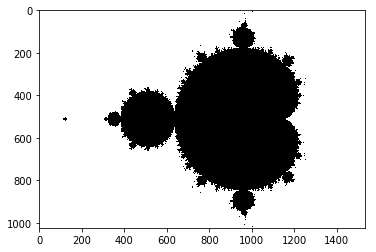

In [59]:
perfect_model = PerfectModel()
res = generate_visualization(perfect_model, 512)
plt.imshow(res, cmap = 'gray')